## This project is from:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import scipy.stats as stats
import pylab
from matplotlib import pyplot
from pandas import set_option
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

#allows printing of all data in cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [128]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


Later We will concat the train and test data together to increase the data size.  The test data does not contain
the Saleprice target.  The train data has 1460 x 80 columns.  The test data has 1459 rows x 79 columns.  Later on when we split the concated data the test size must contain the same number of rows as the original test data.

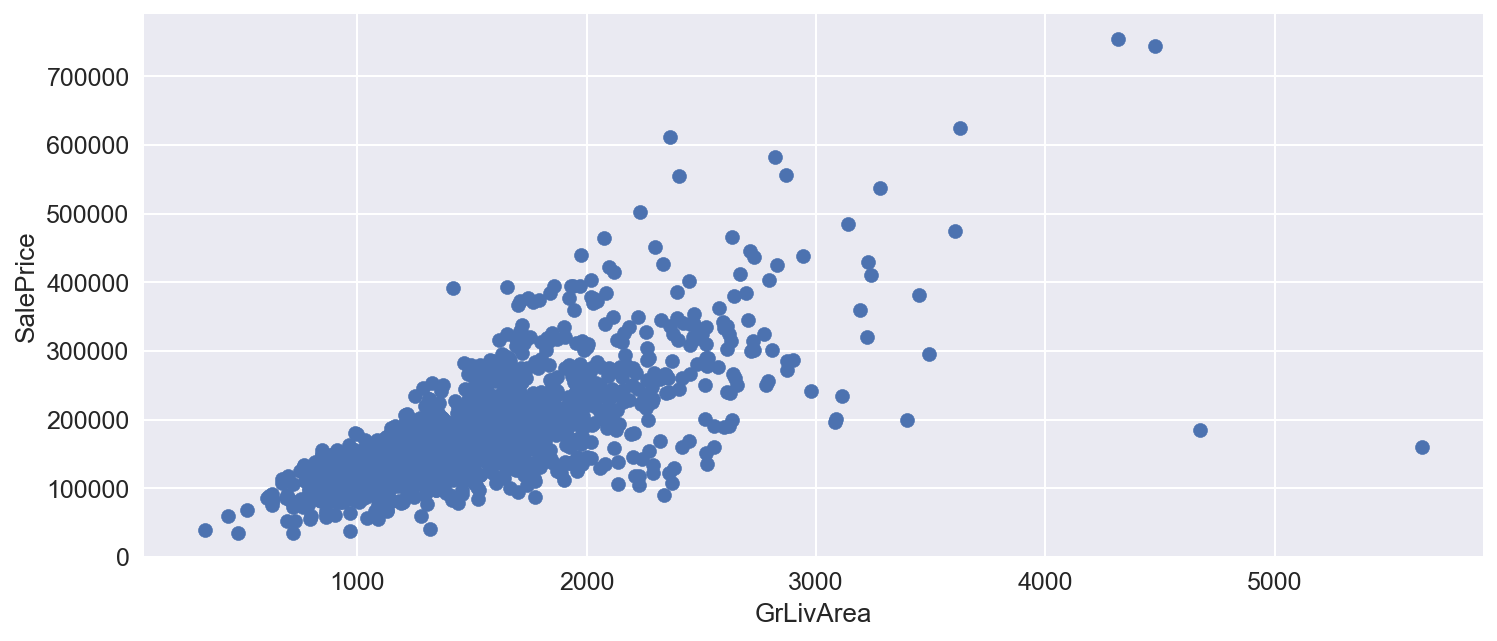

In [97]:
#From kaggle forum and data description we have outliers
fig, ax = plt.subplots(figsize=(12,5));
ax.scatter(x = train['GrLivArea'], y = train['SalePrice']);
plt.ylabel('SalePrice', fontsize=13);
plt.xlabel('GrLivArea', fontsize=13);
plt.show();

#Author of dataset suggests dropping these outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index);

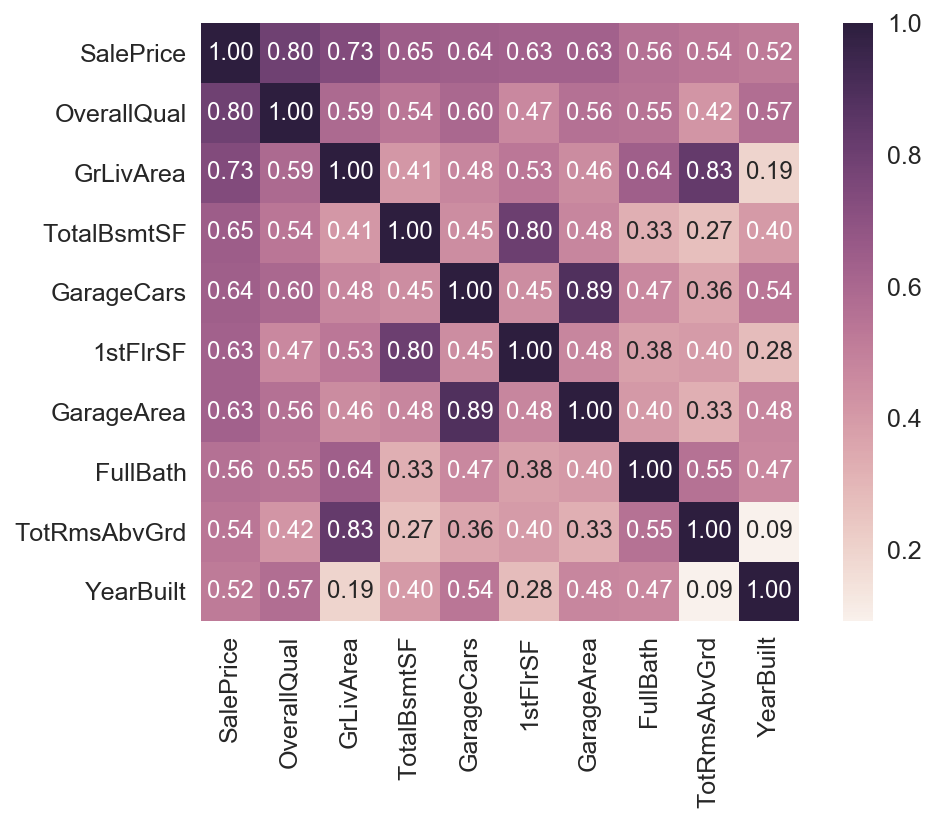

In [98]:
#lets look at correlation bewteen Saleprice and other variables
k = 10 #number of variables for heatmap
corrmat = train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Data preprocessing: 
  
- Transform skewed distributions as regression based tools expect gaussian distributions    
- Process cateogorical variables 
- Replace the nans and missing data

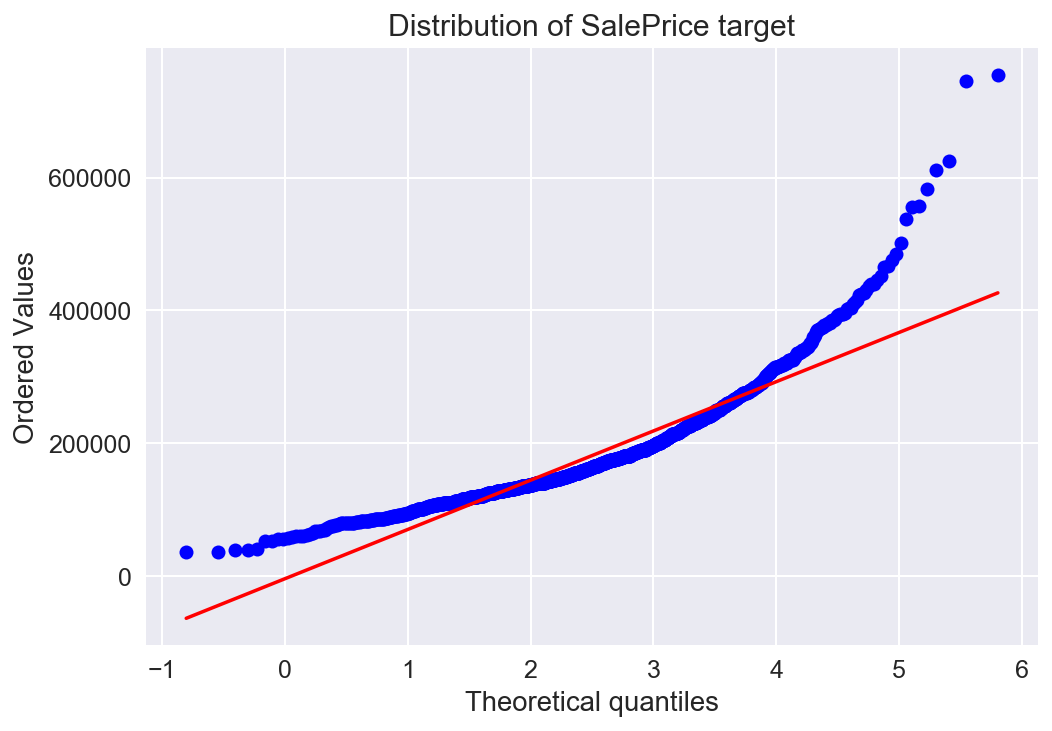

In [99]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(train['SalePrice'], dist='norm', sparams=(2.5,), plot=ax)
ax.set_title("Distribution of SalePrice target")
plt.show();

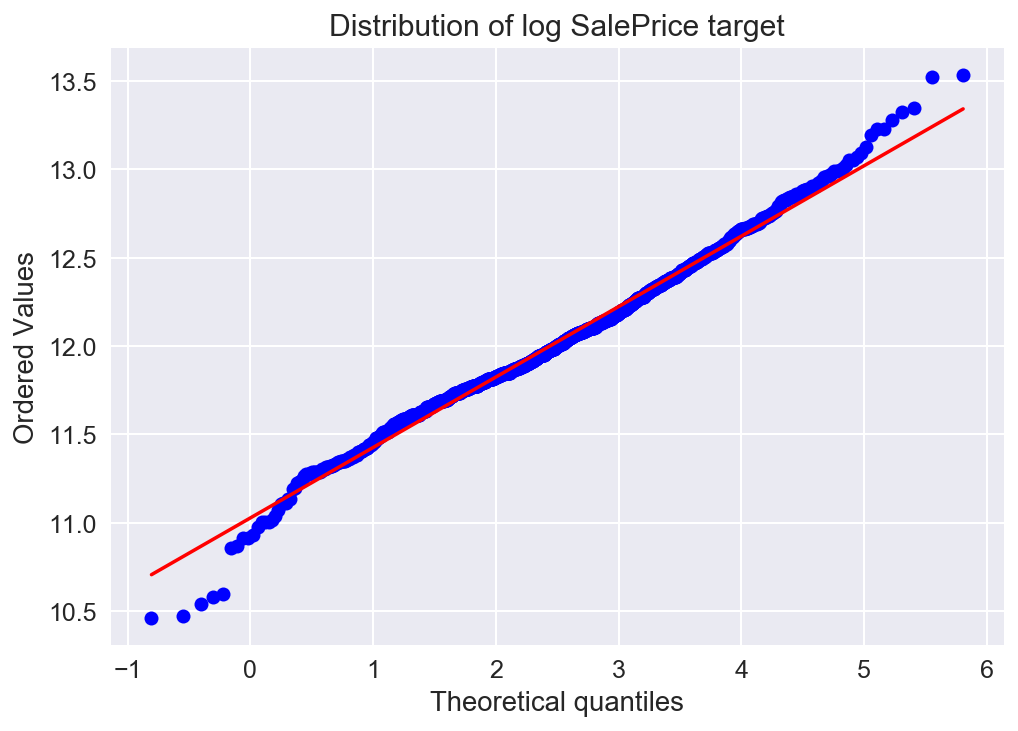

In [100]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(np.log1p(train['SalePrice']), dist='norm', sparams=(2.5,), plot=ax)
ax.set_title("Distribution of log SalePrice target")
plt.show();

In [101]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

Concat the train and test data and save the saleprice target for later.  Save the row count of train and test for later

In [102]:
#concat train and test data together and save sale price target
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("All_data size is : {}".format(all_data.shape))
print("Training data had {} columns, test data has {} columns".format(ntrain,ntest))

All_data size is : (2917, 79)
Training data had 1458 columns, test data has 1459 columns


In [103]:
#Replace missing features
all_data['PoolQC'].fillna('None',inplace=True)
all_data.MiscFeature.fillna('None',inplace=True)

#all_data.Alley.unique()
all_data.Alley.fillna('None',inplace=True);
#all_data.Alley.unique()
#Fence
all_data.Fence.fillna('None',inplace=True);
#Fireplace Qu
all_data.FireplaceQu.fillna('None',inplace=True);
#LotFrontage
all_data.LotFrontage.fillna(all_data.LotFrontage.mean(),inplace=True)

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col].fillna('None',inplace=True) 

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

#GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

#all_data['BsmtCond'].unique()

#BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features,
#NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely
#zero for having no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0) 

#MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for
#the area and None for the type.
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)   

#MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can
#fill in missing values with 'RL'
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
    
#Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . 
#arbritray choice
all_data["Utilities"] = all_data["Utilities"].fillna("NoSeWa")
  
#From data description na is typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")   
    
#Mostly 'SBrkr', we can set that for the missing value.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

#replace with most common
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

#no clas replace with none
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

#replace with most common 
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

#replace with most common
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

# Differentiate numerical features (minus the target) and categorical features
#categorical_features = all_data.select_dtypes(include = ["object"]).columns
#numerical_features = all_data.select_dtypes(exclude = ["object"]).columns

#print("Numerical features : " + str(len(numerical_features)))
#print("Categorical features : " + str(len(categorical_features)))

print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [104]:
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [105]:

# Encode some categorical features as ordered numbers when there is information in the order
all_data = all_data.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}
                            }
                     )
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [106]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [107]:
#split numerical and categorical features for further processing
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
cat_feats = all_data.dtypes[all_data.dtypes == "object"].index

print("Numerical features : " + str(len(numeric_feats)))
print("Categorical features : " + str(len(cat_feats)))

all_data_num = all_data[numeric_feats]
all_data_cat = all_data[cat_feats]


Numerical features : 42
Categorical features : 37


In [108]:
print("NAs in numeric data : " + str(all_data_num.isnull().values.sum()))

NAs in numeric data : 0


In [109]:
# Log transform of the skewed numerical features to lessen impact of outliers
skewed_feats = all_data_num[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.5]
skewed_feats = skewed_feats.index

all_data_num[skewed_feats] = np.log1p(all_data_num[skewed_feats])
print("all_data size is : {}".format(all_data_num.shape))

/Users/rich/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


all_data size is : (2917, 42)


In [110]:
#apply one hot encoding to categorical variables
print('Length of categorical features before one hot encoding:{}'.format(len(all_data_cat.columns)))
all_data_cat = pd.get_dummies(all_data_cat)
print('Length of categorical features after one hot encoding:{}'.format(len(all_data_cat.columns)))

Length of categorical features before one hot encoding:37
Length of categorical features after one hot encoding:268


In [111]:
#Join numeric and categorical features together
all_data = pd.concat([all_data_num,all_data_cat],axis = 1)
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,6.753438,6.751101,0.0,3,6.561031,0.0,0.693147,0.000000,5.017280,0.000000,...,0,0,0,0,1,0,0,1,0,0
1,7.141245,0.000000,0.0,3,6.886532,0.0,0.000000,0.693147,5.652489,0.000000,...,0,0,0,0,1,0,1,0,0,0
2,6.825460,6.765039,0.0,3,6.188264,0.0,0.693147,0.000000,6.075346,0.000000,...,0,0,0,0,1,0,0,1,0,0
3,6.869014,6.629363,0.0,3,5.379897,0.0,0.693147,0.000000,6.293419,5.609472,...,0,0,0,0,1,1,0,0,0,0
4,7.044033,6.960348,0.0,4,6.486161,0.0,0.693147,0.000000,6.196444,0.000000,...,0,0,0,0,1,0,0,1,0,0


In [112]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()
print("all_data size is : {}".format(all_data.shape))

,Missing Ratio


all_data size is : (2917, 310)


In [113]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 310)


In [114]:
#Scale the numeric features
std = StandardScaler()
all_data.loc[:,numeric_feats] = std.fit_transform(all_data.loc[:,numeric_feats]) 

#all_data.loc[:,numeric_feats].describe()

In [115]:
train = all_data[:ntrain]
test = all_data[ntrain:]
#train.shape
#test.shape
#all_data.shape
#ntrain
#These value lengths must match
len(y_train)
len(train.values)

1458

1458

In [116]:
# Partition the dataset in train + validation sets
test_size = 0.2
seed = 7
X_train, X_test, y_train, y_test = train_test_split(train.values, y_train, test_size = test_size, random_state = seed)

In [117]:
#not currently used
def train_and_evaluate(clf, X_train, y_train):
    clf.fit(X_train, y_train)
    print ("Coefficient of determination on training set:{}".format(clf.score(X_train, y_train)))
    kfold = KFold(n_splits=10, random_state=seed)
    scores = cross_val_score(clf, X_train, y_train, cv=kfold)
    print ("Average coefficient of determination using 5-foldcrossvalidation:{}".format(np.mean(scores)))

from sklearn import ensemble
clf_et=ensemble.ExtraTreesRegressor(n_estimators=10,random_state=42)
#train_and_evaluate(clf_et, X_train, y_train)
#features = (list(zip(clf_et.feature_importances_,train.columns)))
#features.sort(reverse=True) 

### Baseline Evaluation of algorithms: Linear and Non-Linear

In [118]:
# test options and evaluation metric
num_folds = 10
num = 7
scoring = 'neg_mean_squared_error'
# spot check algorithms
models = []
models.append(('LASSO', Lasso()))
models.append(('RIDGE', Ridge()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [119]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = np.sqrt((-cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)))
    results.append(cv_results)
    names.append(name)
    msg = "{:s} RMSE {:f} STD {:f} ".format(name, cv_results.mean(), cv_results.std())
    print(msg)

LASSO RMSE 0.394253 STD 0.022346 
RIDGE RMSE 0.113324 STD 0.011418 
EN RMSE 0.394253 STD 0.022346 
KNN RMSE 0.172721 STD 0.022385 
CART RMSE 0.203215 STD 0.019793 
SVR RMSE 0.119308 STD 0.019102 


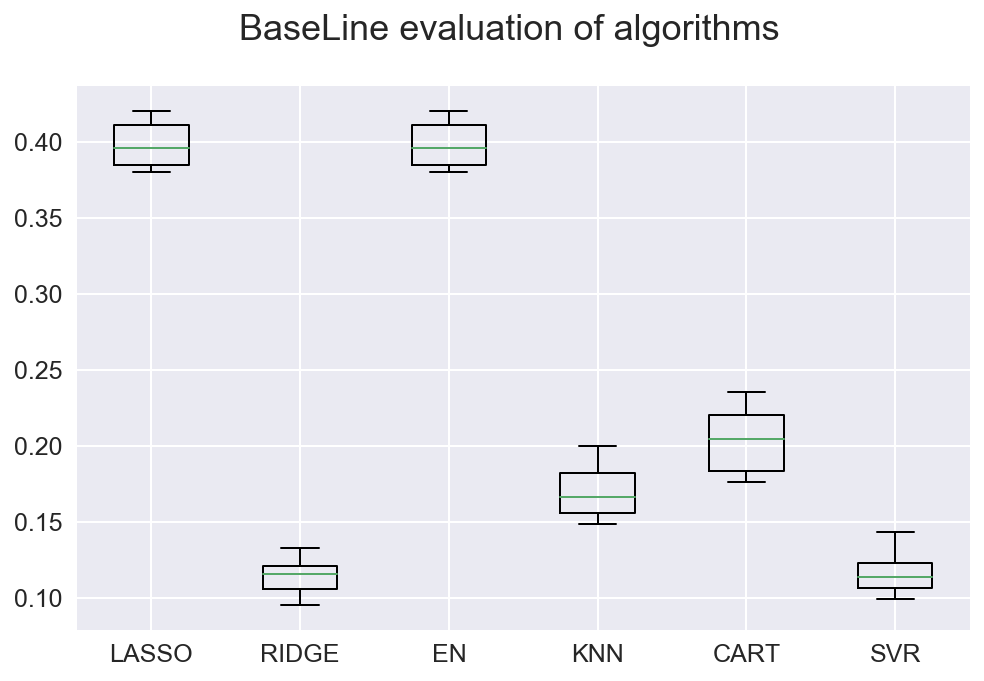

In [120]:
fig = plt.figure(figsize=(8,5))
fig.suptitle('BaseLine evaluation of algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

Ridge and SVR produce better results.  Both Lasso and EN produce worse results compared to Ridge.  We now have large number of variables because we have used get_dummies function to transform the categorical variables.  Is Ridge 'better' when dealing with the large number of variables in this case compared to the other regression techniques?.  Ridge includes all (or none) of the features and shrinks some to small values.  Lasso along with shrinking coefficients performs feature selection as well.  SVR also performs well but is a more complex a solution than Ridge regression.

### Tuning with GridSearch

In [121]:
alpha = [0.1,0.3,0.5,0.1,1.0,1,5,6,7,8,10]
solver = ['auto']
param_grid = dict(alpha=alpha,solver=solver)
model = Ridge()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("RMSE results:")
means = np.sqrt(-grid_result.cv_results_[ 'mean_test_score' ])
stds = grid_result.cv_results_[ 'std_test_score' ]
params = grid_result.cv_results_[ 'params' ]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.012320 using {'alpha': 7, 'solver': 'auto'}
RMSE results:
0.119598 (0.002616) with: {'alpha': 0.1, 'solver': 'auto'}
0.117145 (0.002559) with: {'alpha': 0.3, 'solver': 'auto'}
0.115781 (0.002549) with: {'alpha': 0.5, 'solver': 'auto'}
0.119598 (0.002616) with: {'alpha': 0.1, 'solver': 'auto'}
0.113906 (0.002579) with: {'alpha': 1.0, 'solver': 'auto'}
0.113906 (0.002579) with: {'alpha': 1, 'solver': 'auto'}
0.111095 (0.002872) with: {'alpha': 5, 'solver': 'auto'}
0.111018 (0.002918) with: {'alpha': 6, 'solver': 'auto'}
0.110997 (0.002957) with: {'alpha': 7, 'solver': 'auto'}
0.111013 (0.002991) with: {'alpha': 8, 'solver': 'auto'}
0.111111 (0.003047) with: {'alpha': 10, 'solver': 'auto'}


### Baseline Evaluation of algorithms: Ensemble Methods

In [122]:
ensembles = []
ensembles.append(('AB', AdaBoostRegressor()))
ensembles.append(('GBM', GradientBoostingRegressor()))
ensembles.append(('RF', RandomForestRegressor()))
ensembles.append(('ET', ExtraTreesRegressor()))

In [123]:
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = np.sqrt((-cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)))
    results.append(cv_results)
    names.append(name)
    msg = "%s: RMSE: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: RMSE: 0.158844 (0.016241)
GBM: RMSE: 0.122040 (0.009197)
RF: RMSE: 0.146961 (0.012548)
ET: RMSE: 0.149931 (0.013882)


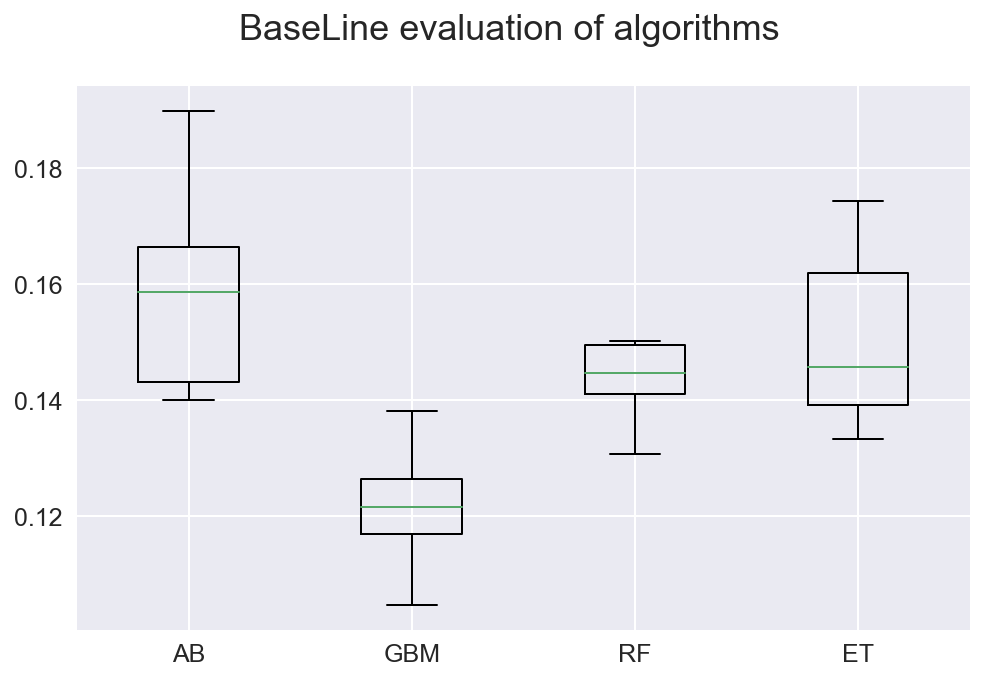

In [124]:
fig = plt.figure(figsize=(8,5))
fig.suptitle('BaseLine evaluation of algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

### Tuning GBM with GridSearch

In [125]:
# Tune scaled GBM
param_grid = dict(n_estimators=np.array([50,150,200]))
model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
means = np.sqrt(-means)
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("RMSE: %f (%f) with: %r" % (mean, stdev, param))

Best: -0.014229 using {'n_estimators': 200}
RMSE: 0.131027 (0.002857) with: {'n_estimators': 50}
RMSE: 0.120116 (0.001958) with: {'n_estimators': 150}
RMSE: 0.119285 (0.001799) with: {'n_estimators': 200}


### Evaluation of Ridge Regression on test set

In [126]:
model = Ridge(alpha=7)
model.fit(X_train,y_train)
kfold = KFold(n_splits=num_folds, random_state=seed)
rmse = np.sqrt((-cross_val_score(model, X_test, y_test, cv=kfold, scoring=scoring)))
rmse.mean()

Ridge(alpha=7, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

0.13968493727007242